# Projeto de Ciência de Dados 2020
---
# Casos confirmados de COVID-19 e impactos no setor de Turismo

---

### Autoria:

- Bruno Eduardo P. Walter,bruno.walter@ifpr.edu.br, <a href = "https://gitlab.com/bruno.walter">@bruno.walter</a>
 
- Cláudia de O. G. de Siqueira, klauguima@gmail.com, <a href = "https://gitlab.com/klauguima">@klauguima</a>

- Gabriel P. Peres, gab_peres@hotmail.com, <a href = "https://gitlab.com/gabperes">@gabperes</a>
---

### Objetivos do Trabalho: 
- Existe alguma associação entre o crescimento do número de casos de COVID-19 e as alterações no número de viagens aéreas nacionais/internacionais tendo por origem/destino as diversas regiões do Brasil (Norte, Sul, Nordeste, Centro-Oeste, Sudeste), ao longo do ano de 2020?
- Considerando as diversas regiões do Brasil (Norte, Sul, Nordeste, Centro-Oeste, Sudeste), existe correlação entre o crescimento de casos confirmados de COVID-19 e o número de admissões e de demissões no setor de turismo, ao longo do ano de 2020?
- Qual a região do Brasil (Norte, Sul, Nordeste, Centro-Oeste, Sudeste) que teve maior impacto em relação ao saldo de vagas de emprego formal abertas/fechadas no setor de turismo, ao longo do ano de 2020?

---

# Bibliotecas

1. <a href = "https://numpy.org/">Numpy</a>
2. <a href = "https://pandas.pydata.org/">Pandas</a>
3. <a href = "https://matplotlib.org/">Matplotlib</a>
4. <a href = "https://docs.python.org/3/library/urllib.request.html">URL Retrieve</a>
5. <a href = "https://docs.python.org/pt-br/3/library/zipfile.html"> Zip file</a>
6. <a href = "https://chardet.github.io/">Chardet</a>
7. <a href = "https://seaborn.pydata.org/">Seaborn</a>
8. <a href = "https://docs.python.org/pt-br/3/library/datetime.html">Data Time</a>
9. <a href = "https://docs.python.org/3/library/re.html">Regular expression operations</a>
10. <a href = "https://py7zr.readthedocs.io/en/latest/">Py7zr</a>
11.  <a href = "https://plotly.com/">Plotly</a>
12. <a href = "https://www.scipy.org/">Scipy</a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.dates import date2num
from urllib.request import urlretrieve
import zipfile
import chardet
import seaborn as sns
import datetime
import re
import py7zr
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
from scipy.stats import pearsonr
from sklearn import preprocessing

---
# Funções

In [2]:
#Função para normalizar dados
def normalizar(x):
    return [(x[n] - min(x)) / (max(x) - min(x)) for n in range(len(x))]

#Função para para ler arquivos csv
def ler_arquivos(arquivo):
    with open(arquivo, 'rb') as rawdata:
        result = chardet.detect(rawdata.read(100000))
    result
    arquivo = pd.read_csv(arquivo, encoding='ISO-8859-1', delimiter=';')
    return arquivo

#Função para poder extrair os arquivos comprimidos 7z
def extrair_7z(arquivo):
    with py7zr.SevenZipFile(arquivo, 'r') as archive:
        archive.extract()
        
#Função para calcucar o aumento percentual
def percentual(arquivo):
    return arquivo.pct_change()

#Função para normalizar por 100mil habitantes
def normalizar_100(x, regiao,n_hab):
    
    #Estimativa da população do ano 2020
    """norte = 18672591
    nordeste = 57374243
    sudeste = 89012240
    sul = 30192315
    centro = 1650403
    """    
    return (x/regiao)*n_hab


# Função para criar legenda referênte a quantidade exata de número de viagens, localizada acima das barras
def draw_plot(regiao, qtd_regiao2019, qtd_regiao2020, titulo, leg_x, leg_y):
    
    #Função para criar legenda detalhada da quantidade de números de viagens 
    def draw_plot(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),fontsize=17,
                    xytext=(0, 3),  # Posição da legenda
                    textcoords="offset points",
                    ha='center', va='bottom')
            
    x = np.arange(len(regiao))  
    width = 0.35

    fig, ax = plt.subplots(figsize=(20,10))
    rects1 = ax.bar(x - width/2, qtd_regiao2019, width, label='2019')
    rects2 = ax.bar(x + width/2, qtd_regiao2020, width, label='2020')

    # Legendas gerais
    ax.set_title(titulo, fontsize=30,  fontweight='bold')
    ax.set_xlabel(leg_x, fontsize= 25, fontweight='bold')
    ax.set_ylabel(leg_y, fontsize=25, fontweight='bold')    
    ax.set_xticks(x)
    ax.set_xticklabels(regiao, fontsize=18)
    ax.legend(fontsize=25)
    plt.yticks(fontsize=18)

    draw_plot(rects1)
    draw_plot(rects2)

    fig.tight_layout()

    plt.show()        

# Download, leitura e extração dos dados

Fontes:    
- <a href = "https://www.anac.gov.br/assuntos/setor-regulado/empresas/envio-de-informacoes/base-de-dados-estatisticos-do-transporte-aereo">ANAC - Agência Nacional de Aviação Civil</a>
- <a href = "https://aps.saude.gov.br/ape/esus">Ministério da Saúde - E-SUS</a>
- <a href = "http://pdet.mte.gov.br/novo-caged">Novo CAGED - Cadastro Geral de Empregados e Desempregados</a>

Links para realizar o dowload da base de dados:

In [3]:
#Links para download da base de dados
url_anac_2019 = 'https://www.anac.gov.br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2019.csv'
url_anac_2020 = 'https://www.anac.gov.br/assuntos/dados-e-estatisticas/dados-estatisticos/arquivos/resumo_anual_2020.csv'

url_covid_saude = 'https://mobileapps.saude.gov.br/esus-vepi/files/unAFkcaNDeXajurGB7LChj8SgQYS2ptm/184e969134bcc50abcaa997e8f551113_HIST_PAINEL_COVIDBR_27nov2020.csv'

url_caged_Mov_1 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202001.7z'
url_caged_Mov_2 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202002.7z'
url_caged_Mov_3 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202003.7z'
url_caged_Mov_4 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202004.7z'
url_caged_Mov_5 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202005.7z'
url_caged_Mov_6 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202006.7z'
url_caged_Mov_7 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202007.7z'
url_caged_Mov_8 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202008.7z'
url_caged_Mov_9 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Movimenta%C3%A7%C3%B5es/2020/Setembro/CAGEDMOV202009.7z'

url_caged_Est_1 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202001.7z'
url_caged_Est_2 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202002.7z'
url_caged_Est_3 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202003.7z'
url_caged_Est_4 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202004.7z'
url_caged_Est_5 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202005.7z'
url_caged_Est_6 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202006.7z'
url_caged_Est_7 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202007.7z'
url_caged_Est_8 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202008.7z'
url_caged_Est_9 = 'ftp://ftp.mtps.gov.br/pdet/microdados/NOVO%20CAGED/Estabelecimentos/Outubro/CAGEDESTAB202009.7z'

url_ibge = 'https://ftp.ibge.gov.br/Estimativas_de_Populacao/Estimativas_2020/POP2020_20201030.xls'

Download e leitura  dos dados do IBGE sobre a estimativa da população:

In [4]:
#Download dos dados
urlretrieve(url_ibge, 'POP2020_20201030.xls')

('POP2020_20201030.xls', <http.client.HTTPMessage at 0x7f13402cdac0>)

In [5]:
#Ler arquivos
hab_regiao = pd.read_excel("POP2020_20201030.xls")

Download e leitura dos dados da ANAC:

In [6]:
#Download dos dados
urlretrieve(url_anac_2019, 'resumo_anual_2019.csv')
urlretrieve(url_anac_2020, 'resumo_anual_2020.csv')

('resumo_anual_2020.csv', <http.client.HTTPMessage at 0x7f13124f49a0>)

In [7]:
#Ler arquivos
data_2019 = ler_arquivos('resumo_anual_2019.csv')
data_2020 = ler_arquivos('resumo_anual_2020.csv')

Download e leitura dos dados do E-SUS:

In [8]:
#Download dos dados
urlretrieve(url_covid_saude, 'covid_saude.csv')

('covid_saude.csv', <http.client.HTTPMessage at 0x7f1311f758e0>)

In [9]:
#Ler arquivos
data_covid_saude = ler_arquivos('covid_saude.csv')

Download e extração dos dados da CAGED Estabelecimento:

In [10]:
#Download dos dados
urlretrieve(url_caged_Est_1, 'caged_est_1.7z')
urlretrieve(url_caged_Est_2, 'caged_est_2.7z')
urlretrieve(url_caged_Est_3, 'caged_est_3.7z')
urlretrieve(url_caged_Est_4, 'caged_est_4.7z')
urlretrieve(url_caged_Est_5, 'caged_est_5.7z')
urlretrieve(url_caged_Est_6, 'caged_est_6.7z')
urlretrieve(url_caged_Est_7, 'caged_est_7.7z')
urlretrieve(url_caged_Est_8, 'caged_est_8.7z')
urlretrieve(url_caged_Est_9, 'caged_est_9.7z')
#Extrair arquivo 7z
extrair_7z('caged_est_1.7z')
extrair_7z('caged_est_2.7z')
extrair_7z('caged_est_3.7z')
extrair_7z('caged_est_4.7z')
extrair_7z('caged_est_5.7z')
extrair_7z('caged_est_6.7z')
extrair_7z('caged_est_7.7z')
extrair_7z('caged_est_8.7z')
extrair_7z('caged_est_9.7z')

Download e extração dos dados da CAGED Movimentação:

In [11]:
#Download dos dados
urlretrieve(url_caged_Mov_1, 'caged_1.7z')
urlretrieve(url_caged_Mov_2, 'caged_2.7z')
urlretrieve(url_caged_Mov_3, 'caged_3.7z')
urlretrieve(url_caged_Mov_4, 'caged_4.7z')
urlretrieve(url_caged_Mov_5, 'caged_5.7z')
urlretrieve(url_caged_Mov_6, 'caged_6.7z')
urlretrieve(url_caged_Mov_7, 'caged_7.7z')
urlretrieve(url_caged_Mov_8, 'caged_8.7z')
urlretrieve(url_caged_Mov_9, 'caged_9.7z')
#Extrair os arquivos
extrair_7z('caged_1.7z')
extrair_7z('caged_2.7z')
extrair_7z('caged_3.7z')
extrair_7z('caged_4.7z')
extrair_7z('caged_5.7z')
extrair_7z('caged_6.7z')
extrair_7z('caged_7.7z')
extrair_7z('caged_8.7z')
extrair_7z('caged_9.7z')

Ler dados do CAGED Estabelecimento/Movimentação:

In [12]:
#Ler arquivo do CAGED Estabelecimento
data_caged_est_1 = pd.read_csv('CAGEDESTAB202001.txt', delimiter=';')
data_caged_est_2 = pd.read_csv('CAGEDESTAB202002.txt', delimiter=';')
data_caged_est_3 = pd.read_csv('CAGEDESTAB202003.txt', delimiter=';')
data_caged_est_4 = pd.read_csv('CAGEDESTAB202004.txt', delimiter=';')
data_caged_est_5 = pd.read_csv('CAGEDESTAB202005.txt', delimiter=';')
data_caged_est_6 = pd.read_csv('CAGEDESTAB202006.txt', delimiter=';')
data_caged_est_7 = pd.read_csv('CAGEDESTAB202007.txt', delimiter=';')
data_caged_est_8 = pd.read_csv('CAGEDESTAB202008.txt', delimiter=';')
data_caged_est_9 = pd.read_csv('CAGEDESTAB202009.txt', delimiter=';')

#Ler arquivos do CAGED Movimentação
data_caged_1 = pd.read_csv('CAGEDMOV202001.txt', delimiter=';')
data_caged_2 = pd.read_csv('CAGEDMOV202002.txt', delimiter=';')
data_caged_3 = pd.read_csv('CAGEDMOV202003.txt', delimiter=';')
data_caged_4 = pd.read_csv('CAGEDMOV202004.txt', delimiter=';')
data_caged_5 = pd.read_csv('CAGEDMOV202005.txt', delimiter=';')
data_caged_6 = pd.read_csv('CAGEDMOV202006.txt', delimiter=';')
data_caged_7 = pd.read_csv('CAGEDMOV202007.txt', delimiter=';')
data_caged_8 = pd.read_csv('CAGEDMOV202008.txt', delimiter=';')
data_caged_9 = pd.read_csv('CAGEDMOV202009.txt', delimiter=';')

Concatenação dos dados:

In [13]:
#ANAC
data = pd.concat([data_2019, data_2020])

In [14]:
#CAGED Estabelecimento
data_caged_est = pd.concat([data_caged_est_1, data_caged_est_2,data_caged_est_3,data_caged_est_4,data_caged_est_5,data_caged_est_6, data_caged_est_7, data_caged_est_8, data_caged_est_9])

In [15]:
#CAGED Movimentação
data_caged_1 = data_caged_1.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_1 = data_caged_1[((data_caged_1['subclasse']==7911200) | (data_caged_1['subclasse']==7912100))]

data_caged_2 = data_caged_2.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_2 = data_caged_2[((data_caged_2['subclasse']==7911200) | (data_caged_2['subclasse']==7912100))]

data_caged_3 = data_caged_3.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_3 = data_caged_3[((data_caged_3['subclasse']==7911200) | (data_caged_3['subclasse']==7912100))]

data_caged_4 = data_caged_4.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_4 = data_caged_4[((data_caged_4['subclasse']==7911200) | (data_caged_4['subclasse']==7912100))]

data_caged_5 = data_caged_5.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_5 = data_caged_5[((data_caged_5['subclasse']==7911200) | (data_caged_5['subclasse']==7912100))]

data_caged_6 = data_caged_6.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_6 = data_caged_6[((data_caged_6['subclasse']==7911200) | (data_caged_6['subclasse']==7912100))]

data_caged_7 = data_caged_7.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_7 = data_caged_7[((data_caged_7['subclasse']==7911200) | (data_caged_7['subclasse']==7912100))]

data_caged_8 = data_caged_8.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_8 = data_caged_8[((data_caged_8['subclasse']==7911200) | (data_caged_8['subclasse']==7912100))]

data_caged_9 = data_caged_9.filter(items = ['competência', 'região', 'subclasse', 'tipomovimentação', 'sexo'])
data_caged_9 = data_caged_9[((data_caged_9['subclasse']==7911200) | (data_caged_9['subclasse']==7912100))]

caged_mov = pd.concat([data_caged_1, data_caged_2,data_caged_3,data_caged_4,data_caged_5,data_caged_6, data_caged_7, data_caged_8, data_caged_9])

# Estimativa da População
---

In [16]:
#Tratamento dos dados do IBGE
hab_regiao = hab_regiao.rename(columns={'ESTIMATIVAS DA POPULAÇÃO RESIDENTE NO BRASIL E UNIDADES DA FEDERAÇÃO COM DATA DE REFERÊNCIA EM 1º DE JULHO DE 2020':'Regiao', 'Unnamed: 2':'Quantidade'})

hab_regiao = hab_regiao.filter(items=['Regiao','Quantidade' ])

hab_regiao_norte = hab_regiao[(hab_regiao['Regiao'] == 'Região Norte')]
hab_regiao_norte = hab_regiao_norte['Quantidade']

hab_regiao_nordeste = hab_regiao[(hab_regiao['Regiao'] == 'Região Nordeste')]
hab_regiao_nordeste = hab_regiao_nordeste['Quantidade']

hab_regiao_sudeste = hab_regiao[(hab_regiao['Regiao'] == 'Região Sudeste')]
hab_regiao_sudeste = hab_regiao_sudeste['Quantidade']

hab_regiao_sul = hab_regiao[(hab_regiao['Regiao'] == 'Região Sul')]
hab_regiao_sul = hab_regiao_sul['Quantidade']

hab_regiao_centro = hab_regiao[(hab_regiao['Regiao'] == 'Região Centro-Oeste')]
hab_regiao_centro = hab_regiao_centro['Quantidade']

#Estimativa da população do ano 2020
norte = 18672591
nordeste = 57374243
sudeste = 89012240
sul = 30192315
centro = 16504303  
geral = norte+nordeste+sudeste+sul+centro
hab = 100000  

# Dados do COVID-19
---

### a) Tratamento e separação dos dados:

In [17]:
#Realiza um filtro para selecionar apenas determinadas colunas
covid = data_covid_saude.filter(items = ['regiao', 'data','municipio', 'casosNovos'])

#Realiza condição para selecionar apenas no Brasil
covid = covid[(covid['regiao'] != 'Brasil')]

covid = covid.dropna()

#Realiza o tratamendo da data, para a coluna data seja preenchida apenas com um valor respectivo ao mês
covid['data'] = pd.to_datetime(covid['data'], errors='coerce')
covid['data'] = covid['data'].dt.month

#Realiza algumas condições para selecionar o período e  a quantidade de casos por mês e região
covid = covid[(covid['data'] <= 9)].groupby(['regiao', 'data']).sum().reset_index()
covid_geral = covid[(covid['data'] <= 9)].groupby(['data']).sum().reset_index()
covid_norte = covid[(covid['regiao'] == 'Norte')].reset_index()
covid_sul = covid[(covid['regiao'] == 'Sul')].reset_index()
covid_sudeste = covid[(covid['regiao'] == 'Sudeste')].reset_index()
covid_centro = covid[(covid['regiao'] == 'Centro-Oeste')].reset_index()
covid_nordeste= covid[(covid['regiao'] == 'Nordeste')].reset_index()


---
### b) Gráfico dos Casos mensais de Covid-19 por Região
Não Normalizado:

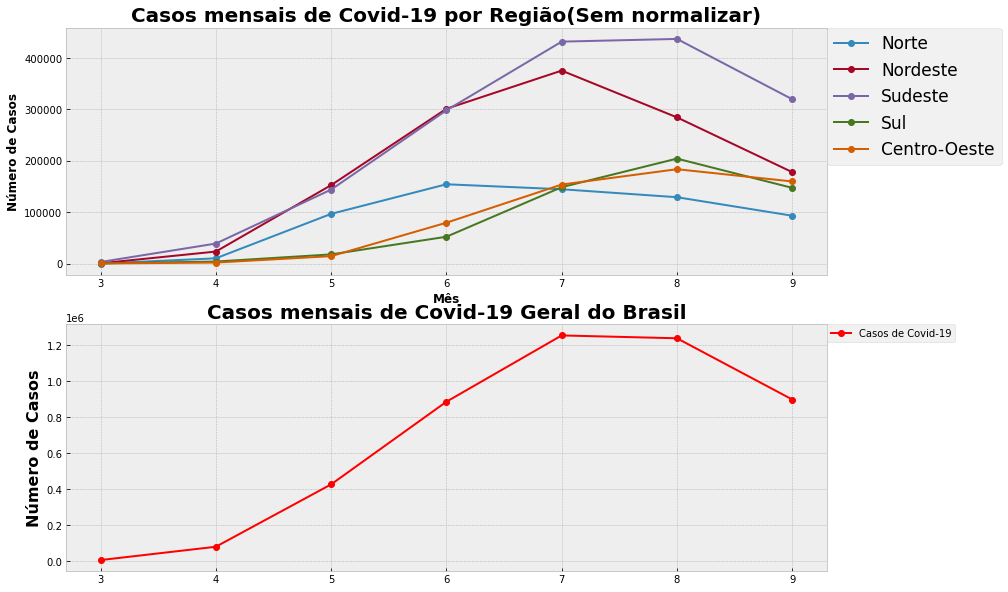

In [18]:
plt.style.use('bmh') 
plt.figure(figsize=(30,10))
plt.subplot(221)

plt.plot(covid_norte['data'], covid_norte['casosNovos'],'-o' , label = 'Norte')
plt.plot(covid_nordeste['data'], covid_nordeste['casosNovos'],'-o' , label = 'Nordeste')
plt.plot(covid_sudeste['data'], covid_sudeste['casosNovos'],'-o' , label = 'Sudeste')
plt.plot(covid_sul['data'], covid_sul['casosNovos'],'-o' , label = 'Sul')
plt.plot(covid_centro['data'], covid_centro['casosNovos'],'-o' , label = 'Centro-Oeste')
plt.title('Casos mensais de Covid-19 por Região(Sem normalizar)', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.xlabel('Mês', fontsize=12, fontweight='bold')


plt.subplot(223)
plt.plot(covid_geral['data'], covid_geral['casosNovos'] ,'-o', color ='Red',  label = 'Casos de Covid-19')
plt.title('Casos mensais de Covid-19 Geral do Brasil', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=16, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.show()

---
Normalizado(0,1):

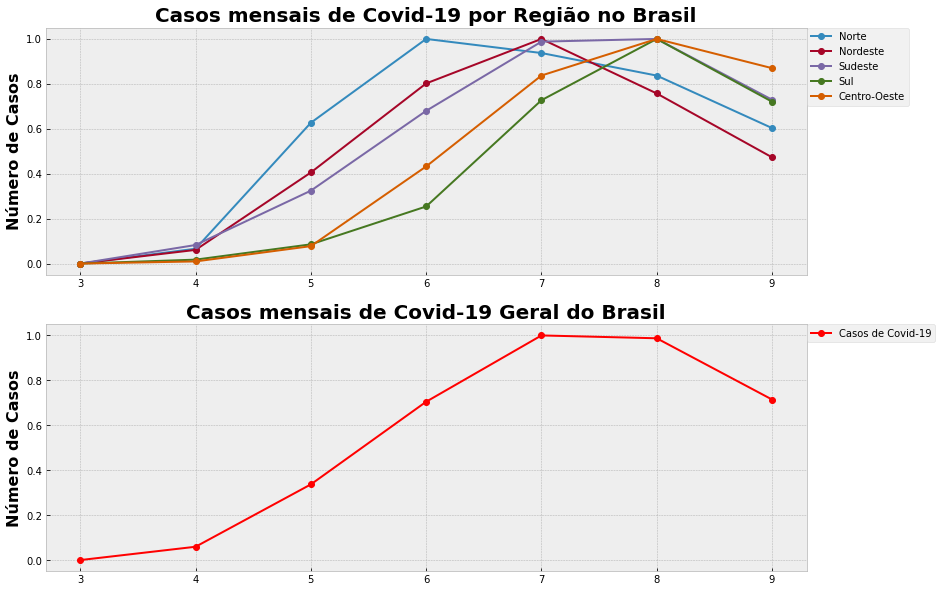

In [19]:
n_covid_geral = normalizar(covid_geral['casosNovos'])

n_covid_norte = normalizar(covid_norte['casosNovos'])
n_covid_nordeste = normalizar(covid_nordeste['casosNovos'])
n_covid_sudeste = normalizar(covid_sudeste['casosNovos'])
n_covid_sul = normalizar(covid_sul['casosNovos'])
n_covid_centro = normalizar(covid_centro['casosNovos'])

plt.style.use('bmh') 
plt.figure(figsize=(30,10))

plt.subplot(221)
plt.plot(covid_norte['data'], n_covid_norte ,'-o' , label = 'Norte')
plt.plot(covid_nordeste['data'], n_covid_nordeste,'-o' , label = 'Nordeste')
plt.plot(covid_sudeste['data'], n_covid_sudeste,'-o' , label = 'Sudeste')
plt.plot(covid_sul['data'], n_covid_sul,'-o' , label = 'Sul')
plt.plot(covid_centro['data'], n_covid_centro,'-o' , label = 'Centro-Oeste')
plt.title('Casos mensais de Covid-19 por Região no Brasil', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=16, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.subplot(223)
plt.plot(covid_geral['data'], n_covid_geral ,'-o', color ='Red',  label = 'Casos de Covid-19')
plt.title('Casos mensais de Covid-19 Geral do Brasil', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=16, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.show()



---
Normalizado(por 100 mil habitantes):

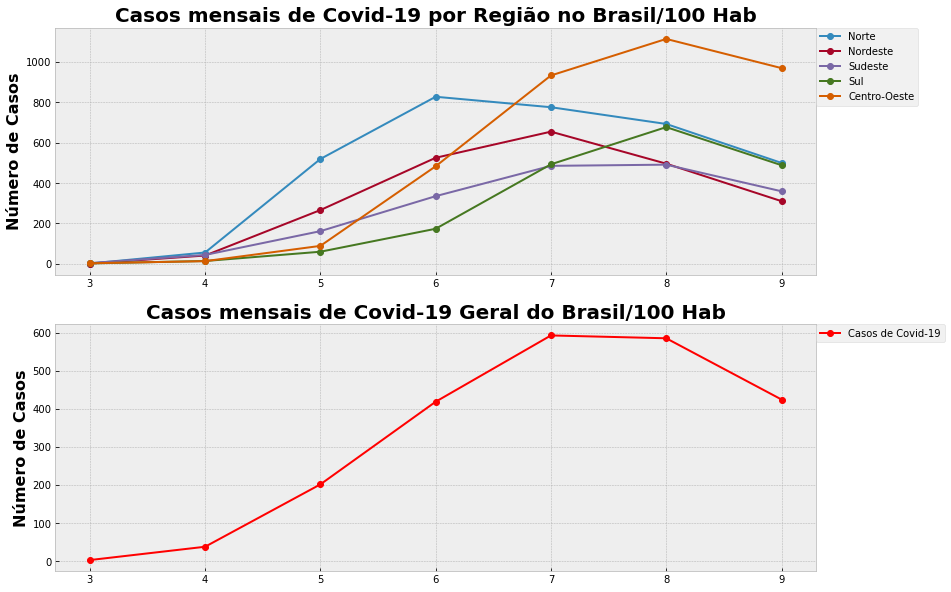

In [20]:
h_covid_geral = normalizar_100(covid_geral['casosNovos'],geral,hab)

h_covid_norte = normalizar_100(covid_norte['casosNovos'], norte, hab)
h_covid_nordeste = normalizar_100(covid_nordeste['casosNovos'], nordeste, hab)
h_covid_sudeste = normalizar_100(covid_sudeste['casosNovos'], sudeste, hab)
h_covid_sul = normalizar_100(covid_sul['casosNovos'], sul, hab)
h_covid_centro = normalizar_100(covid_centro['casosNovos'], centro, hab)

plt.style.use('bmh') 
plt.figure(figsize=(30,10))

plt.subplot(221)
plt.plot(covid_norte['data'], h_covid_norte ,'-o' , label = 'Norte')
plt.plot(covid_nordeste['data'], h_covid_nordeste,'-o' , label = 'Nordeste')
plt.plot(covid_sudeste['data'], h_covid_sudeste,'-o' , label = 'Sudeste')
plt.plot(covid_sul['data'], h_covid_sul,'-o' , label = 'Sul')
plt.plot(covid_centro['data'], h_covid_centro,'-o' , label = 'Centro-Oeste')
plt.title('Casos mensais de Covid-19 por Região no Brasil/100 Hab', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=16, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)

plt.subplot(223)
plt.plot(covid_geral['data'], h_covid_geral ,'-o', color ='Red',  label = 'Casos de Covid-19')
plt.title('Casos mensais de Covid-19 Geral do Brasil/100 Hab', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=16, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0.)
plt.show()



# Viagens Áereas realizadas por ano

---

### a) Tratamento e separação dos dados:

In [21]:
#Realiza um filtro para selecionar apenas determinadas colunas
origem_regiao = data.filter(items=['AEROPORTO DE ORIGEM (REGIÃO)', 'ANO', 'MÊS'])

#Retira os valores vazios
origem_regiao = origem_regiao.dropna()

#Realiza um groupby e depois um count para verificar a quantidade de viagens realizadas
origem_regiao2019 = origem_regiao[((origem_regiao['ANO']==2019) & 
                                   (origem_regiao['MÊS']<10) & 
                                   (origem_regiao['AEROPORTO DE ORIGEM (REGIÃO)']!='NÃO IDENTIFICADO'))].groupby(['AEROPORTO DE ORIGEM (REGIÃO)']).count().reset_index().sort_values(['ANO'], ascending=False)
origem_regiao2020 = origem_regiao[((origem_regiao['ANO']==2020) & 
                                   (origem_regiao['MÊS']<10))].groupby(['AEROPORTO DE ORIGEM (REGIÃO)']).count().reset_index().sort_values(['ANO'], ascending=False)

origem_pais = data.filter(items=['AEROPORTO DE ORIGEM (PAÍS)', 'ANO', 'MÊS'])
origem_pais = origem_pais.dropna()

origem_pais2020 = origem_pais[((origem_pais['ANO']==2020) & 
                               (origem_pais['MÊS']<10))].groupby(['AEROPORTO DE ORIGEM (PAÍS)']).count().reset_index().sort_values(['ANO'], ascending=False).head(5)
origem_pais2019 = origem_pais[((origem_pais['ANO']==2019) & 
                               (origem_pais['MÊS']<10))].groupby(['AEROPORTO DE ORIGEM (PAÍS)']).count().reset_index().sort_values(['ANO'], ascending=False).head(5)

---
### b) Gráfico de viagens realizadas por região e país(2019/2020)

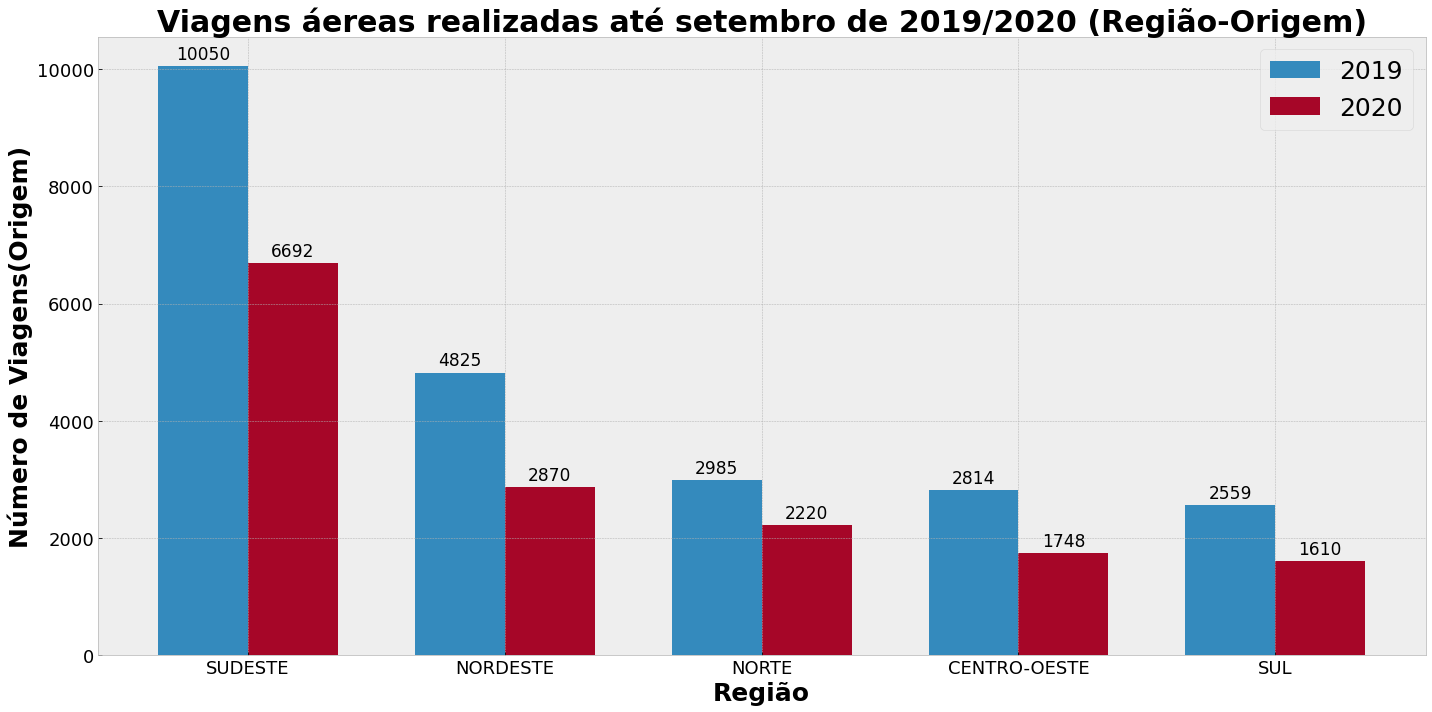

In [22]:
regiao = origem_regiao2020['AEROPORTO DE ORIGEM (REGIÃO)']
qtd_regiao2019 = origem_regiao2019['ANO']
qtd_regiao2020 = origem_regiao2020['ANO']
titulo = 'Viagens áereas realizadas até setembro de 2019/2020 (Região-Origem)'
leg_x = 'Região'
leg_y = 'Número de Viagens(Origem)'
draw_plot(regiao, qtd_regiao2019, qtd_regiao2020, titulo, leg_x, leg_y)

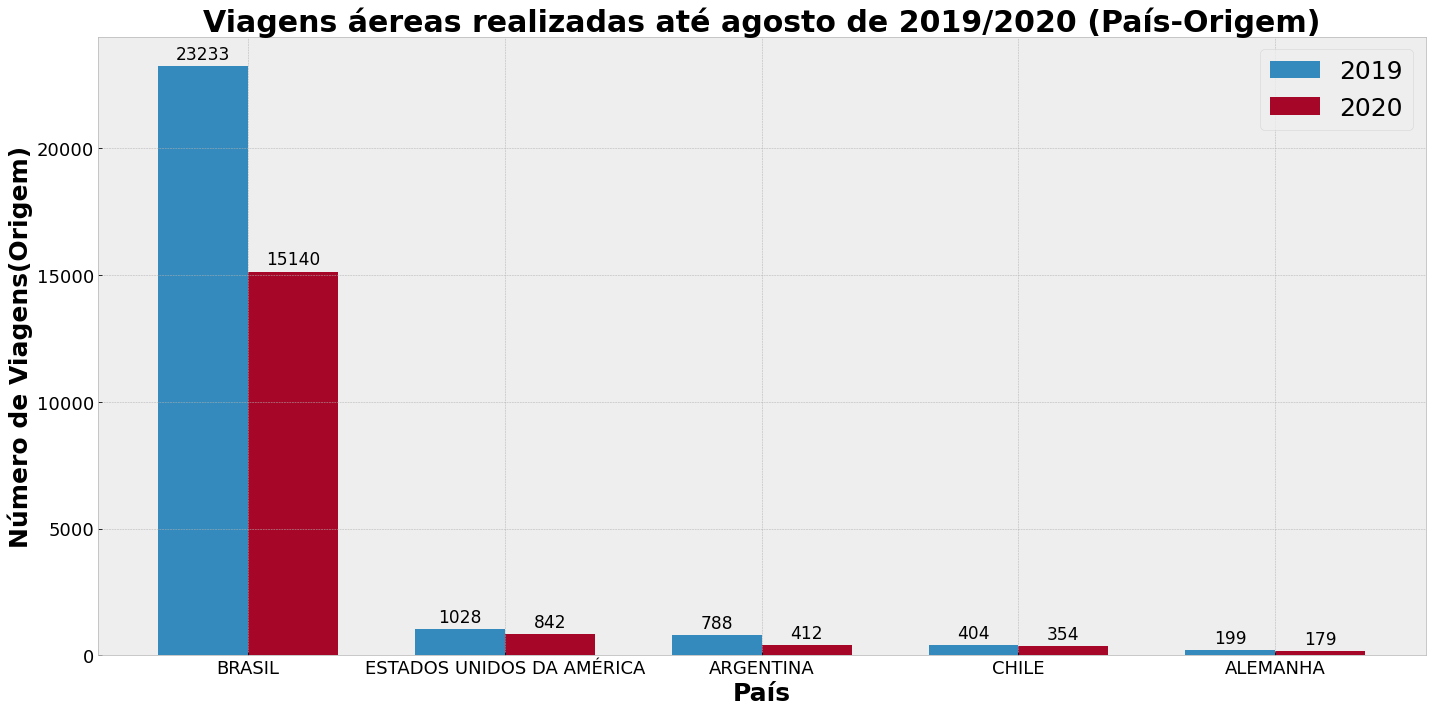

In [23]:
pais = origem_pais2020['AEROPORTO DE ORIGEM (PAÍS)']
origem_pais2019 = origem_pais2019['ANO']
origem_pais2020 = origem_pais2020['ANO']
titulo = 'Viagens áereas realizadas até agosto de 2019/2020 (País-Origem)'
leg_x = 'País'
leg_y = 'Número de Viagens(Origem)'
draw_plot(pais, origem_pais2019, origem_pais2020, titulo, leg_x, leg_y)

# Viagens Áereas realizadas por mês

---

### a) Tratamento e separação dos dados:

In [24]:
# Origem Região Mês 2020

origem_regiao_mes = data.filter(items=['AEROPORTO DE ORIGEM (PAÍS)','ANO', 'MÊS', 'AEROPORTO DE ORIGEM (REGIÃO)'])
origem_regiao_mes2019 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2019) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_regiao_mes2020 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2020) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)

origem_norte_mes2019 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='NORTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2019) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_nordeste_mes2019 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='NORDESTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2019) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_sudeste_mes2019 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='SUDESTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2019) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_sul_mes2019 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='SUL') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2019) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_centro_mes2019 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='CENTRO-OESTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2019) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)


origem_norte_mes2020 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='NORTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2020) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_nordeste_mes2020 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='NORDESTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2020) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_sudeste_mes2020 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='SUDESTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2020) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_sul_mes2020 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='SUL') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2020) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)
origem_centro_mes2020 = origem_regiao_mes[((origem_regiao_mes['AEROPORTO DE ORIGEM (REGIÃO)'] =='CENTRO-OESTE') & (origem_regiao_mes['AEROPORTO DE ORIGEM (PAÍS)'] =='BRASIL') & (origem_regiao_mes['ANO']==2020) & (origem_regiao_mes['MÊS']<=9) & (origem_regiao_mes['MÊS']>1))].groupby(['MÊS']).count().reset_index().sort_values(['MÊS'], ascending=True)

---
### b) Gráfico das Viagens Áereas por Região:

Não Normalizado:

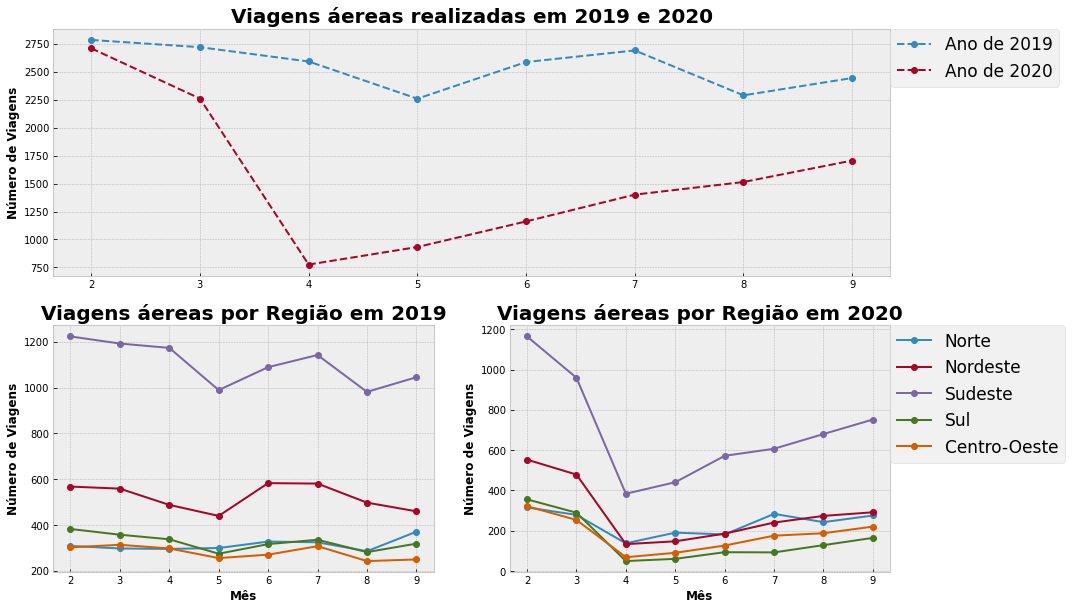

In [25]:
plt.style.use('bmh') 
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(origem_regiao_mes2019['MÊS'],origem_regiao_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], '--o', label = 'Ano de 2019')
plt.plot(origem_regiao_mes2020['MÊS'],origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], '--o', label = 'Ano de 2020')
plt.title('Viagens áereas realizadas em 2019 e 2020', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 

plt.subplot(223)
plt.plot(origem_norte_mes2019['MÊS'],origem_norte_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Origem 2019')
plt.plot(origem_nordeste_mes2019['MÊS'],origem_nordeste_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Origem 2019')
plt.plot(origem_sudeste_mes2019['MÊS'],origem_sudeste_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Origem 2019')
plt.plot(origem_sul_mes2019['MÊS'],origem_sul_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Origem 2019')
plt.plot(origem_centro_mes2019['MÊS'],origem_centro_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Origem 2019')
plt.title('Viagens áereas por Região em 2019', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 

plt.subplot(224)
plt.plot(origem_norte_mes2020['MÊS'],origem_norte_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Norte')
plt.plot(origem_nordeste_mes2020['MÊS'],origem_nordeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Nordeste')
plt.plot(origem_sudeste_mes2020['MÊS'],origem_sudeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Sudeste')
plt.plot(origem_sul_mes2020['MÊS'],origem_sul_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Sul')
plt.plot(origem_centro_mes2020['MÊS'],origem_centro_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], '-o', label = 'Centro-Oeste')
plt.title('Viagens áereas por Região em 2020', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.xlabel('Mês', fontsize=12, fontweight='bold') 
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 

plt.show()

---
Normalizado(0,1):

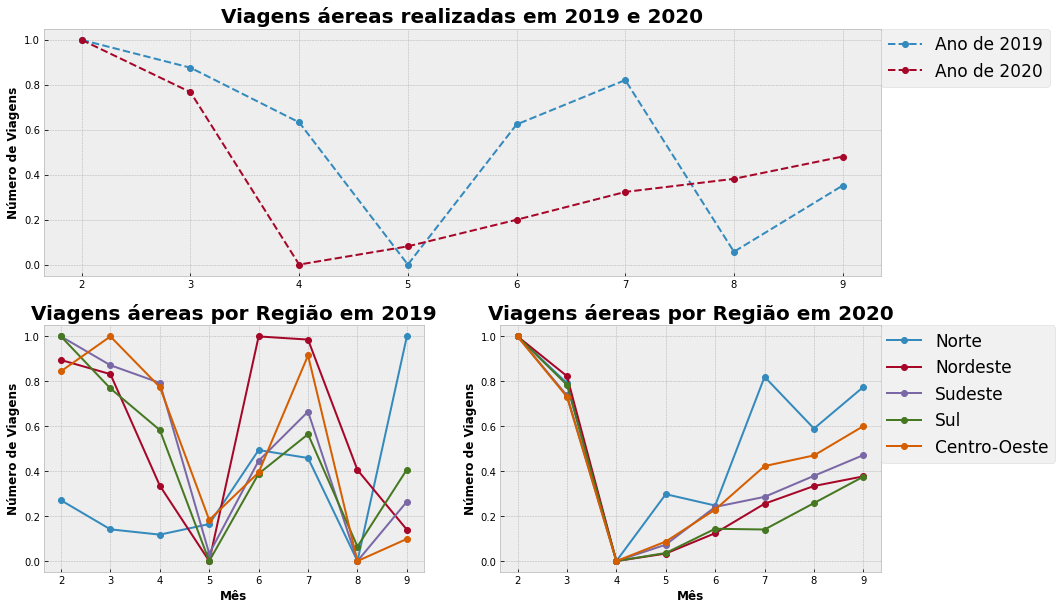

In [26]:
#Normalizar dados
n_origem_regiao_mes2019 = normalizar(origem_regiao_mes2019['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_regiao_mes2020 = normalizar(origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])

n_origem_norte_mes2019 = normalizar(origem_norte_mes2019['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_nordeste_mes2019 = normalizar(origem_nordeste_mes2019['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_sudeste_mes2019 = normalizar(origem_sudeste_mes2019['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_sul_mes2019 = normalizar(origem_sul_mes2019['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_centro_mes2019 = normalizar(origem_centro_mes2019['AEROPORTO DE ORIGEM (PAÍS)'])

n_origem_norte_mes2020= normalizar(origem_norte_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_nordeste_mes2020 = normalizar(origem_nordeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_sudeste_mes2020 = normalizar(origem_sudeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_sul_mes2020 = normalizar(origem_sul_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])
n_origem_centro_mes2020 = normalizar(origem_centro_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])

plt.style.use('bmh') 
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(origem_regiao_mes2019['MÊS'],n_origem_regiao_mes2019, '--o', label = 'Ano de 2019')
plt.plot(origem_regiao_mes2020['MÊS'],n_origem_regiao_mes2020, '--o', label = 'Ano de 2020')
plt.title('Viagens áereas realizadas em 2019 e 2020', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 

plt.subplot(223)
plt.plot(origem_norte_mes2019['MÊS'],n_origem_norte_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_nordeste_mes2019['MÊS'],n_origem_nordeste_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_sudeste_mes2019['MÊS'],n_origem_sudeste_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_sul_mes2019['MÊS'],n_origem_sul_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_centro_mes2019['MÊS'],n_origem_centro_mes2019, '-o', label = 'Origem 2019')
plt.title('Viagens áereas por Região em 2019', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 

plt.subplot(224)
plt.plot(origem_norte_mes2020['MÊS'],n_origem_norte_mes2020, '-o', label = 'Norte')
plt.plot(origem_nordeste_mes2020['MÊS'],n_origem_nordeste_mes2020, '-o', label = 'Nordeste')
plt.plot(origem_sudeste_mes2020['MÊS'],n_origem_sudeste_mes2020, '-o', label = 'Sudeste')
plt.plot(origem_sul_mes2020['MÊS'],n_origem_sul_mes2020, '-o', label = 'Sul')
plt.plot(origem_centro_mes2020['MÊS'],n_origem_centro_mes2020, '-o', label = 'Centro-Oeste')
plt.title('Viagens áereas por Região em 2020', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.xlabel('Mês', fontsize=12, fontweight='bold') 
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 

plt.show()


---
Normalizado(100 mil viagens):

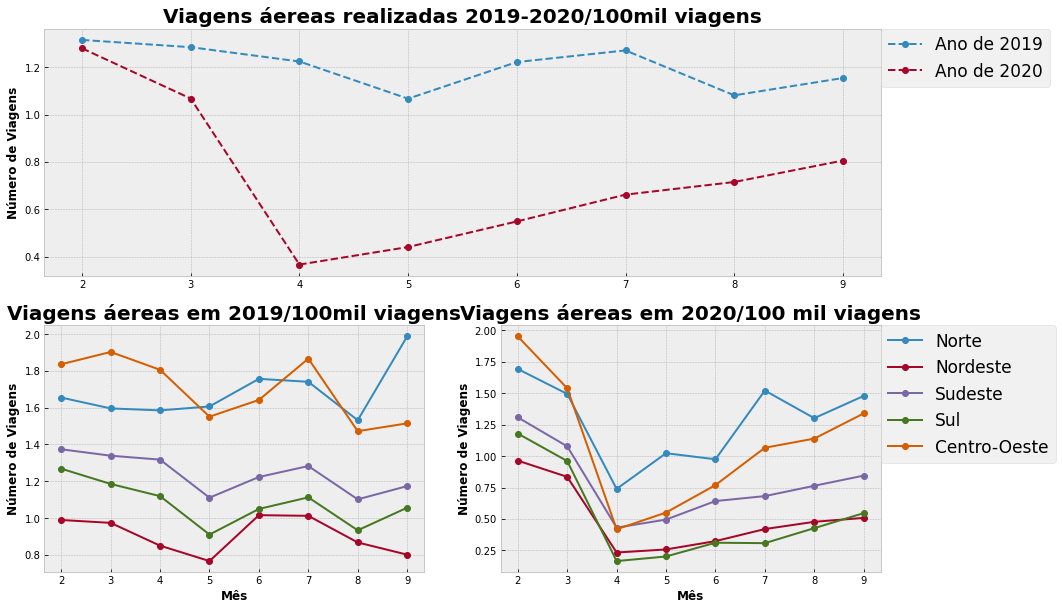

In [27]:
av = 100000

h_origem_regiao_mes2019 = normalizar_100(origem_regiao_mes2019['AEROPORTO DE ORIGEM (PAÍS)'],geral,av)
h_origem_regiao_mes2020 = normalizar_100(origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)'],geral,av)

h_origem_norte_mes2019 = normalizar_100(origem_norte_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], norte, av)
h_origem_nordeste_mes2019 = normalizar_100(origem_nordeste_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], nordeste, av)
h_origem_sudeste_mes2019 = normalizar_100(origem_sudeste_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], sudeste, av)
h_origem_sul_mes2019 = normalizar_100(origem_sul_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], sul, av)
h_origem_centro_mes2019 = normalizar_100(origem_centro_mes2019['AEROPORTO DE ORIGEM (PAÍS)'], centro, av)

h_origem_norte_mes2020 = normalizar_100(origem_norte_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], norte, av)
h_origem_nordeste_mes2020 = normalizar_100(origem_nordeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], nordeste, av)
h_origem_sudeste_mes2020 = normalizar_100(origem_sudeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], sudeste, av)
h_origem_sul_mes2020 = normalizar_100(origem_sul_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], sul, av)
h_origem_centro_mes2020 = normalizar_100(origem_centro_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], centro, av)

plt.style.use('bmh') 
plt.figure(figsize=(15,10))

plt.subplot(211)
plt.plot(origem_regiao_mes2019['MÊS'],h_origem_regiao_mes2019, '--o', label = 'Ano de 2019')
plt.plot(origem_regiao_mes2020['MÊS'],h_origem_regiao_mes2020, '--o', label = 'Ano de 2020')
plt.title('Viagens áereas realizadas 2019-2020/100mil viagens', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 

plt.subplot(223)
plt.plot(origem_norte_mes2019['MÊS'],h_origem_norte_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_nordeste_mes2019['MÊS'],h_origem_nordeste_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_sudeste_mes2019['MÊS'],h_origem_sudeste_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_sul_mes2019['MÊS'],h_origem_sul_mes2019, '-o', label = 'Origem 2019')
plt.plot(origem_centro_mes2019['MÊS'],h_origem_centro_mes2019, '-o', label = 'Origem 2019')
plt.title('Viagens áereas em 2019/100mil viagens', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 

plt.subplot(224)
plt.plot(origem_norte_mes2020['MÊS'],h_origem_norte_mes2020, '-o', label = 'Norte')
plt.plot(origem_nordeste_mes2020['MÊS'],h_origem_nordeste_mes2020, '-o', label = 'Nordeste')
plt.plot(origem_sudeste_mes2020['MÊS'],h_origem_sudeste_mes2020, '-o', label = 'Sudeste')
plt.plot(origem_sul_mes2020['MÊS'],h_origem_sul_mes2020, '-o', label = 'Sul')
plt.plot(origem_centro_mes2020['MÊS'],h_origem_centro_mes2020, '-o', label = 'Centro-Oeste')
plt.title('Viagens áereas em 2020/100 mil viagens', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.xlabel('Mês', fontsize=12, fontweight='bold') 
plt.ylabel('Número de Viagens', fontsize=12, fontweight='bold') 

plt.show()


# CAGED ESTABELECIMENTO
---

### a) Legendas:



Região
   1. Norte - 1   
   2. Nordeste - 2 
   3. Sudeste - 3
   4. Sul - 4
   5. Centro-Oeste - 5
   

  
Subclasses
   1. Agencia de viajens -  7911200 
   2. Op. Turísticos - 7912100
---
### b) Tratamento e separação dos dados:

In [28]:
caged_est = data_caged_est.filter(items = ['competência', 'subclasse', 'região', 'admitidos', 'desligados', 'saldomovimentação'])
caged_est = data_caged_est[((data_caged_est['subclasse']==7911200) | (data_caged_est['subclasse']==7912100))]
caged_est = caged_est.dropna()
caged_est = caged_est[(caged_est['competência'] > 202001) & (caged_est['competência'] <= 202009)].groupby(['região', 'competência'])[['admitidos', 'desligados', 'saldomovimentação']].sum().reset_index()

caged_est_norte = caged_est[(caged_est['região'] == 1)]
caged_est_nordeste= caged_est[(caged_est['região'] == 2)]
caged_est_sudeste = caged_est[(caged_est['região'] == 3)]
caged_est_sul = caged_est[(caged_est['região'] == 4)]
caged_est_centro = caged_est[(caged_est['região'] == 5)]


---
### c) Gerar Gráfico de Desligados, Admitidos e casos do COVID-19

Não Normalizado:

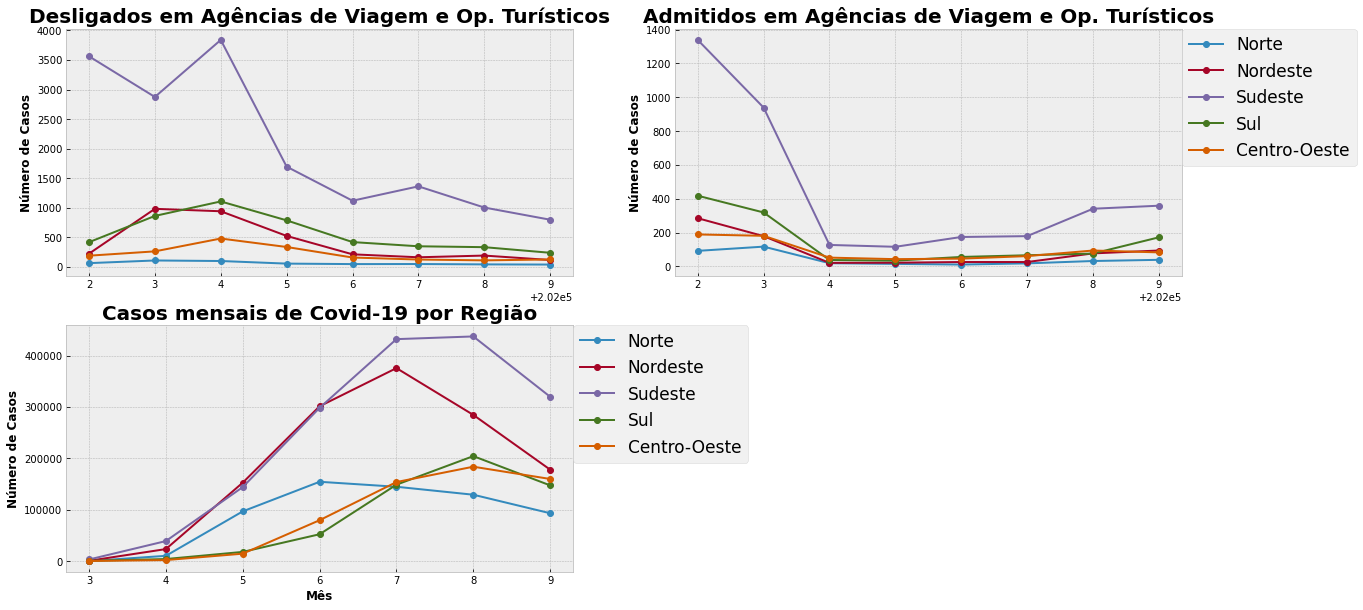

In [29]:
plt.figure(figsize=(20,10))
plt.style.use('bmh') 
plt.subplot(222)
plt.plot(caged_est_norte['competência'], caged_est_norte['admitidos'], '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], caged_est_nordeste['admitidos'], '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], caged_est_sudeste['admitidos'], '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], caged_est_sul['admitidos'], '-o', label = 'Sul')
plt.plot(caged_est_centro['competência'], caged_est_centro['admitidos'], '-o' , label = 'Centro-Oeste')
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Admitidos em Agências de Viagem e Op. Turísticos', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)

plt.subplot(221)
plt.plot(caged_est_norte['competência'], caged_est_norte['desligados'], '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], caged_est_nordeste['desligados'], '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], caged_est_sudeste['desligados'], '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], caged_est_sul['desligados'], '-o' , label = 'Sul')
plt.plot(caged_est_centro['competência'], caged_est_centro['desligados'], '-o' , label = 'Centro-Oeste')
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Desligados em Agências de Viagem e Op. Turísticos', fontsize=20, fontweight='bold') 

plt.subplot(223)
plt.plot(covid_norte['data'], covid_norte['casosNovos'], '-o', label="Norte")
plt.plot(covid_nordeste['data'], covid_nordeste['casosNovos'], '-o', label="Nordeste")
plt.plot(covid_sudeste['data'], covid_sudeste['casosNovos'], '-o', label="Sudeste")
plt.plot(covid_sul['data'], covid_sul['casosNovos'], '-o', label="Sul")
plt.plot(covid_centro['data'], covid_centro['casosNovos'], '-o', label="Centro-Oeste")
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold')
plt.title('Casos mensais de Covid-19 por Região', fontsize=20, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 

plt.show()

---
Normalizado(0,1):

In [30]:
nad_caged_est_norte = normalizar(caged_est_norte['admitidos'].to_numpy())
nad_caged_est_nordeste = normalizar(caged_est_nordeste['admitidos'].to_numpy())
nad_caged_est_sudeste = normalizar(caged_est_sudeste['admitidos'].to_numpy())
nad_caged_est_sul = normalizar(caged_est_sul['admitidos'].to_numpy())
nad_caged_est_centro = normalizar(caged_est_centro['admitidos'].to_numpy())

nd_caged_est_norte = normalizar(caged_est_norte['desligados'].to_numpy())
nd_caged_est_nordeste = normalizar(caged_est_nordeste['desligados'].to_numpy())
nd_caged_est_sudeste = normalizar(caged_est_sudeste['desligados'].to_numpy())
nd_caged_est_sul = normalizar(caged_est_sul['desligados'].to_numpy())
nd_caged_est_centro = normalizar(caged_est_centro['desligados'].to_numpy())

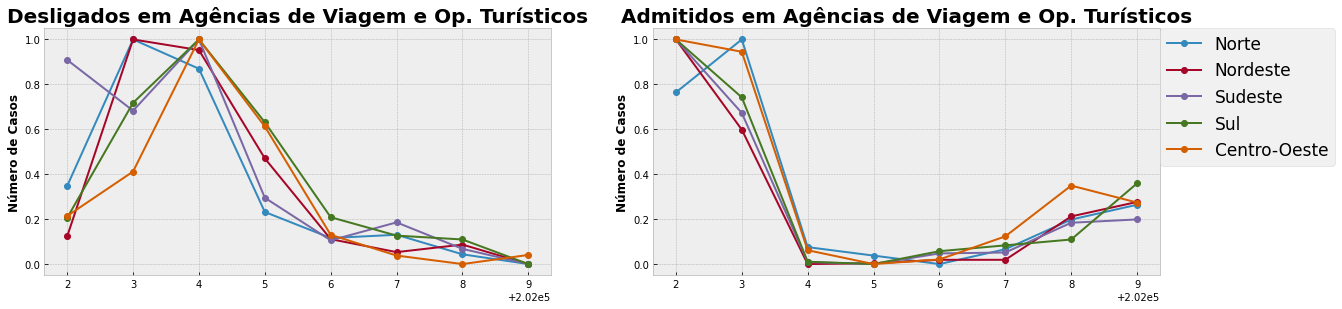

In [31]:
plt.figure(figsize=(20,10))
plt.style.use('bmh') 
plt.subplot(222)
plt.plot(caged_est_norte['competência'], nad_caged_est_norte, '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], nad_caged_est_nordeste, '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], nad_caged_est_sudeste, '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], nad_caged_est_sul, '-o', label = 'Sul')
plt.plot(caged_est_centro['competência'], nad_caged_est_centro, '-o' , label = 'Centro-Oeste')
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Admitidos em Agências de Viagem e Op. Turísticos', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)

plt.subplot(221)
plt.plot(caged_est_norte['competência'], nd_caged_est_norte, '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], nd_caged_est_nordeste, '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], nd_caged_est_sudeste, '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], nd_caged_est_sul, '-o' , label = 'Sul')
plt.plot(caged_est_centro['competência'], nd_caged_est_centro, '-o' , label = 'Centro-Oeste')
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Desligados em Agências de Viagem e Op. Turísticos', fontsize=20, fontweight='bold') 
plt.show()

---
Normalizado(por 100mil habitantes):

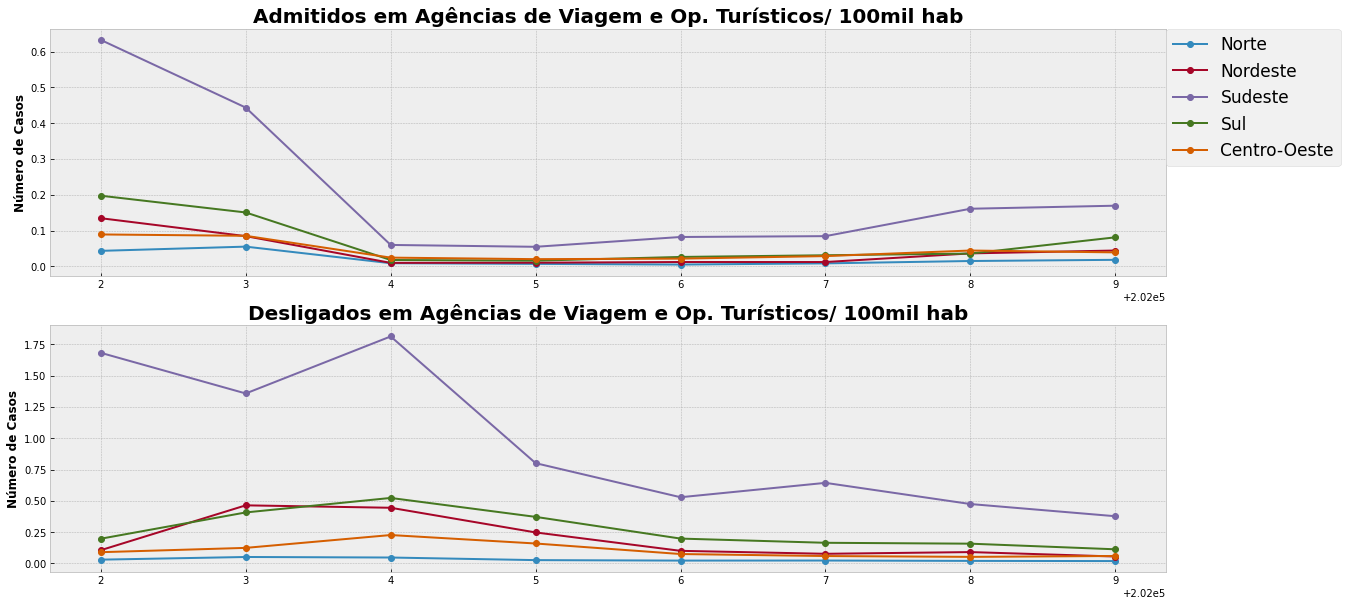

In [32]:
had_caged_est_norte = normalizar_100(caged_est_norte['admitidos'].to_numpy(),geral,hab)
had_caged_est_nordeste = normalizar_100(caged_est_nordeste['admitidos'].to_numpy(),geral,hab)
had_caged_est_sudeste = normalizar_100(caged_est_sudeste['admitidos'].to_numpy(),geral,hab)
had_caged_est_sul = normalizar_100(caged_est_sul['admitidos'].to_numpy(),geral,hab)
had_caged_est_centro = normalizar_100(caged_est_centro['admitidos'].to_numpy(),geral,hab)

hd_caged_est_norte = normalizar_100(caged_est_norte['desligados'].to_numpy(),geral,hab)
hd_caged_est_nordeste = normalizar_100(caged_est_nordeste['desligados'].to_numpy(),geral,hab)
hd_caged_est_sudeste = normalizar_100(caged_est_sudeste['desligados'].to_numpy(),geral,hab)
hd_caged_est_sul = normalizar_100(caged_est_sul['desligados'].to_numpy(),geral,hab)
hd_caged_est_centro = normalizar_100(caged_est_centro['desligados'].to_numpy(),geral,hab)

plt.figure(figsize=(20,10))
plt.style.use('bmh') 
plt.subplot(211)
plt.plot(caged_est_norte['competência'], had_caged_est_norte, '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], had_caged_est_nordeste, '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], had_caged_est_sudeste, '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], had_caged_est_sul, '-o', label = 'Sul')
plt.plot(caged_est_centro['competência'], had_caged_est_centro, '-o' , label = 'Centro-Oeste')
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Admitidos em Agências de Viagem e Op. Turísticos/ 100mil hab', fontsize=20, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)

plt.subplot(212)
plt.plot(caged_est_norte['competência'], hd_caged_est_norte, '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], hd_caged_est_nordeste, '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], hd_caged_est_sudeste, '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], hd_caged_est_sul, '-o' , label = 'Sul')
plt.plot(caged_est_centro['competência'], hd_caged_est_centro, '-o' , label = 'Centro-Oeste')
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Desligados em Agências de Viagem e Op. Turísticos/ 100mil hab', fontsize=20, fontweight='bold') 
plt.show()

### d) Gerar Gráfico de Saldo (Admitidos - Desligados)
Não Normalizado: 

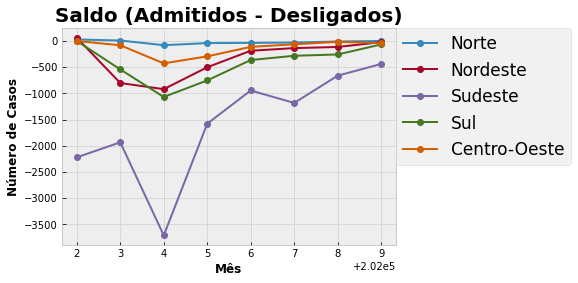

In [33]:
plt.plot(caged_est_norte['competência'], caged_est_norte['saldomovimentação'],'-o', label = 'Norte')
plt.plot(caged_est_nordeste['competência'], caged_est_nordeste['saldomovimentação'], '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], caged_est_sudeste['saldomovimentação'], '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], caged_est_sul['saldomovimentação'], '-o' , label = 'Sul')
plt.plot(caged_est_centro['competência'], caged_est_centro['saldomovimentação'], '-o', label = 'Centro-Oeste')
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Saldo (Admitidos - Desligados)', fontsize=20, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 
plt.show()

---
Normalizado(0,1):

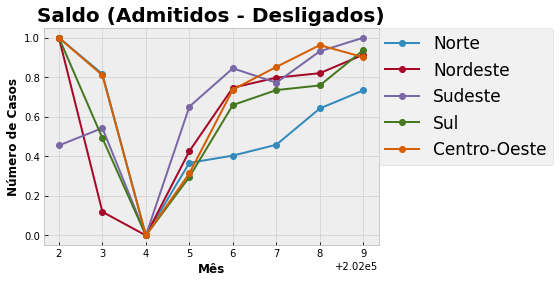

In [34]:
ns_caged_est_norte = normalizar(caged_est_norte['saldomovimentação'].to_numpy())
ns_caged_est_nordeste = normalizar(caged_est_nordeste['saldomovimentação'].to_numpy())
ns_caged_est_sudeste = normalizar(caged_est_sudeste['saldomovimentação'].to_numpy())
ns_caged_est_sul = normalizar(caged_est_sul['saldomovimentação'].to_numpy())
ns_caged_est_centro = normalizar(caged_est_centro['saldomovimentação'].to_numpy())

plt.plot(caged_est_norte['competência'], ns_caged_est_norte, '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], ns_caged_est_nordeste, '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], ns_caged_est_sudeste, '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], ns_caged_est_sul, '-o' , label = 'Sul')
plt.plot(caged_est_centro['competência'], ns_caged_est_centro, '-o' , label = 'Centro-Oeste')
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Saldo (Admitidos - Desligados)', fontsize=20, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 
plt.show()

---
Normalizado(por 100mil habitantes):

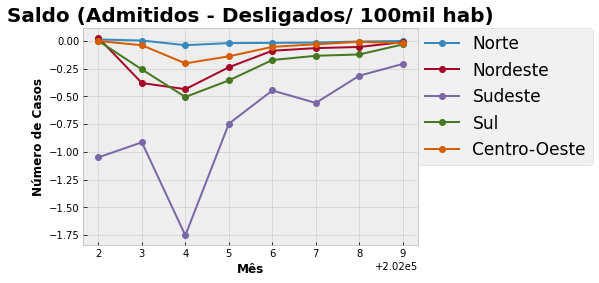

In [35]:
hs_caged_est_norte = normalizar_100(caged_est_norte['saldomovimentação'].to_numpy(),geral,hab)
hs_caged_est_nordeste = normalizar_100(caged_est_nordeste['saldomovimentação'].to_numpy(),geral,hab)
hs_caged_est_sudeste = normalizar_100(caged_est_sudeste['saldomovimentação'].to_numpy(),geral,hab)
hs_caged_est_sul = normalizar_100(caged_est_sul['saldomovimentação'].to_numpy(),geral,hab)
hs_caged_est_centro = normalizar_100(caged_est_centro['saldomovimentação'].to_numpy(),geral,hab)

plt.plot(caged_est_norte['competência'], hs_caged_est_norte, '-o' , label = 'Norte')
plt.plot(caged_est_nordeste['competência'], hs_caged_est_nordeste, '-o' , label = 'Nordeste')
plt.plot(caged_est_sudeste['competência'], hs_caged_est_sudeste, '-o' , label = 'Sudeste')
plt.plot(caged_est_sul['competência'], hs_caged_est_sul, '-o' , label = 'Sul')
plt.plot(caged_est_centro['competência'], hs_caged_est_centro, '-o' , label = 'Centro-Oeste')
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.title('Saldo (Admitidos - Desligados/ 100mil hab)', fontsize=20, fontweight='bold') 
plt.xlabel('Mês', fontsize=12, fontweight='bold') 
plt.show()

# CAGED Movimentação
---
### a) Legenda

Tipo de movimentação
   1. novo emprego (reemprego) - 10
   2. dispensa sem justa causa - 31
   3. dispensa com justa causa - 32
   4. término normal do contrato - 45

    
Sexo
   1. Masculino - 1
   2. Feminino - 3
    
Subclasse
   1. Agencia de viajens - 7911200
   2. Op. Turísticos - 7912100
     
Região
   1. Norte - 1
   2. Nordeste - 2
   3. Sudeste - 3
   4. Sul - 4
   5. Centro-Oeste - 5
---
### b) Tratamento e separação dos dados:


In [36]:
novo_emp = caged_mov[(caged_mov['tipomovimentação'] == 20) & (caged_mov['competência'] > 202001)].groupby(['competência'])['tipomovimentação'].count().reset_index()
dispensa_sem = caged_mov[(caged_mov['tipomovimentação'] == 31) & (caged_mov['competência'] > 202001)].groupby(['competência'])['tipomovimentação'].count().reset_index()
dispensa_com = caged_mov[(caged_mov['tipomovimentação'] == 32) & (caged_mov['competência'] > 202001)].groupby(['competência'])['tipomovimentação'].count().reset_index()
pedido_demissão = caged_mov[(caged_mov['tipomovimentação'] == 40) & (caged_mov['competência'] > 202001)].groupby(['competência'])['tipomovimentação'].count().reset_index()
termino_contrato = caged_mov[(caged_mov['tipomovimentação'] == 45) & (caged_mov['competência'] > 202001)].groupby(['competência'])['tipomovimentação'].count().reset_index()

---
### c) Gerar gráfico tipos de Movimentações em Agências de Viagem e Operadores Turísticos
Não Normalizado:

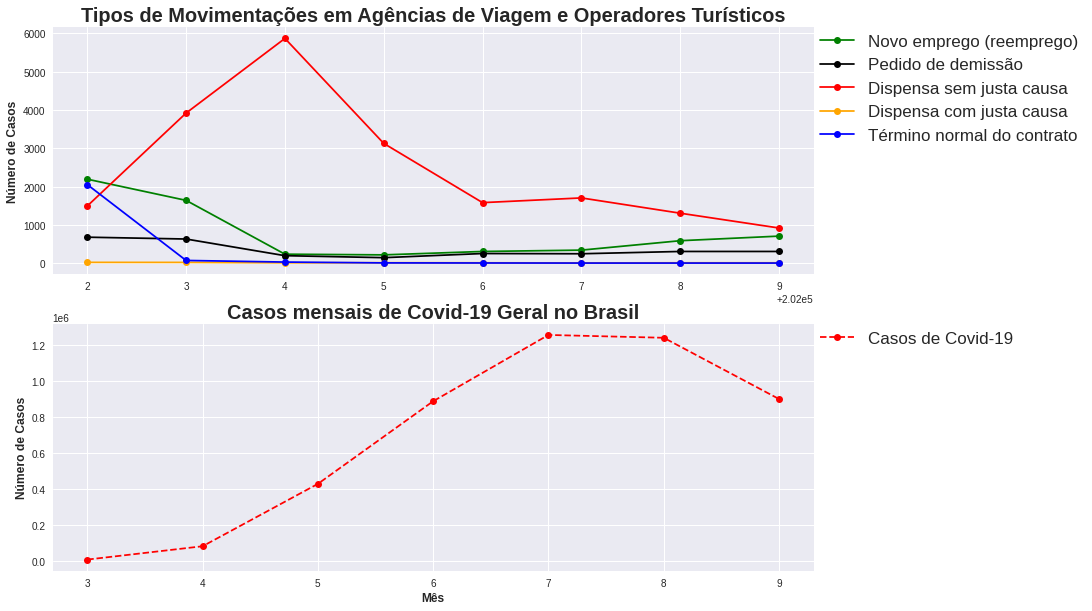

In [37]:
plt.style.use('seaborn') 
plt.figure(figsize=(30,10))

plt.subplot(221)
plt.plot(novo_emp['competência'], novo_emp['tipomovimentação'] , 'o-', color ='Green', label = 'Novo emprego (reemprego)')
plt.plot(pedido_demissão['competência'], pedido_demissão['tipomovimentação'] , 'o-', color ='Black', label = 'Pedido de demissão')
plt.plot(dispensa_sem['competência'], dispensa_sem['tipomovimentação'] , 'o-', color ='Red', label = 'Dispensa sem justa causa')
plt.plot(dispensa_com['competência'], dispensa_com['tipomovimentação'] , 'o-', color ='Orange', label = 'Dispensa com justa causa')
plt.plot(termino_contrato['competência'], termino_contrato['tipomovimentação'] , 'o-', color ='Blue', label = 'Término normal do contrato')
plt.title('Tipos de Movimentações em Agências de Viagem e Operadores Turísticos', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)

plt.subplot(223)
plt.plot(covid_geral['data'], covid_geral['casosNovos'] ,'--o', color ='Red',  label = 'Casos de Covid-19')
plt.title('Casos mensais de Covid-19 Geral no Brasil', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.xlabel('Mês', fontsize=12, fontweight='bold') 

plt.show()

Normalizado(0,1):

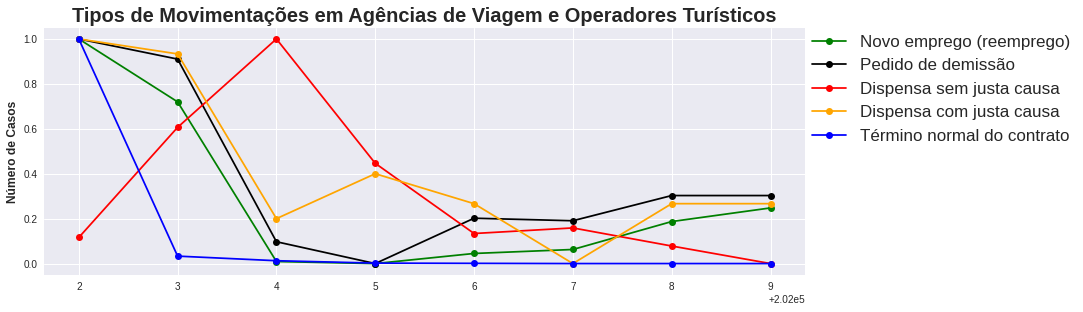

In [38]:
n_novo_emp = normalizar(novo_emp['tipomovimentação'].to_numpy())
n_pedido_demissão = normalizar(pedido_demissão['tipomovimentação'].to_numpy())
n_dispensa_sem = normalizar(dispensa_sem['tipomovimentação'].to_numpy())
n_dispensa_com = normalizar(dispensa_com['tipomovimentação'].to_numpy())
n_termino_contrato = normalizar(termino_contrato['tipomovimentação'].to_numpy())

plt.style.use('seaborn') 
plt.figure(figsize=(30,10))

plt.subplot(221)
plt.plot(novo_emp['competência'], n_novo_emp , 'o-', color ='Green', label = 'Novo emprego (reemprego)')
plt.plot(pedido_demissão['competência'],n_pedido_demissão , 'o-', color ='Black', label = 'Pedido de demissão')
plt.plot(dispensa_sem['competência'], n_dispensa_sem , 'o-', color ='Red', label = 'Dispensa sem justa causa')
plt.plot(dispensa_com['competência'], n_dispensa_com , 'o-', color ='Orange', label = 'Dispensa com justa causa')
plt.plot(termino_contrato['competência'], n_termino_contrato , 'o-', color ='Blue', label = 'Término normal do contrato')
plt.title('Tipos de Movimentações em Agências de Viagem e Operadores Turísticos', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.show()

---
Normalizado(por 100mil habitantes):

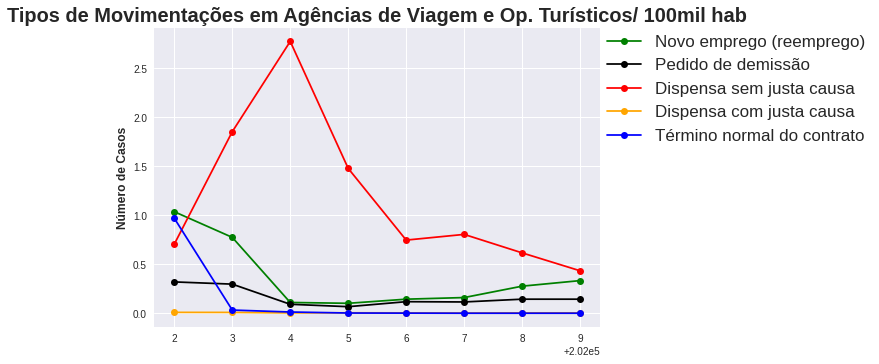

In [39]:
hn_novo_emp = normalizar_100(novo_emp['tipomovimentação'].to_numpy(),geral,hab)
hn_pedido_demissão = normalizar_100(pedido_demissão['tipomovimentação'].to_numpy(),geral,hab)
hn_dispensa_sem = normalizar_100(dispensa_sem['tipomovimentação'].to_numpy(),geral,hab)
hn_dispensa_com = normalizar_100(dispensa_com['tipomovimentação'].to_numpy(),geral,hab)
hn_termino_contrato = normalizar_100(termino_contrato['tipomovimentação'].to_numpy(),geral,hab)

plt.plot(novo_emp['competência'], hn_novo_emp , 'o-', color ='Green', label = 'Novo emprego (reemprego)')
plt.plot(pedido_demissão['competência'],hn_pedido_demissão , 'o-', color ='Black', label = 'Pedido de demissão')
plt.plot(dispensa_sem['competência'], hn_dispensa_sem , 'o-', color ='Red', label = 'Dispensa sem justa causa')
plt.plot(dispensa_com['competência'], hn_dispensa_com , 'o-', color ='Orange', label = 'Dispensa com justa causa')
plt.plot(termino_contrato['competência'], hn_termino_contrato , 'o-', color ='Blue', label = 'Término normal do contrato')
plt.title('Tipos de Movimentações em Agências de Viagem e Op. Turísticos/ 100mil hab', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.show()

---
### d) Gerar gráficos de pedido de demissão e dispensa sem justa causa por região

Tratamento e separação dos dados:

In [40]:
novo_emp = caged_mov[(caged_mov['tipomovimentação'] == 20) & (caged_mov['competência'] > 202001)].groupby(['competência', 'região'])['tipomovimentação'].count().reset_index()
dispensa_sem = caged_mov[(caged_mov['tipomovimentação'] == 31) & (caged_mov['competência'] > 202001)].groupby(['competência', 'região'])['tipomovimentação'].count().reset_index()
pedido_demissão = caged_mov[(caged_mov['tipomovimentação'] == 40) & (caged_mov['competência'] > 202001)].groupby(['competência','região'])['tipomovimentação'].count().reset_index()

novo_emp_norte = novo_emp[(novo_emp['região'] == 1)]
novo_emp_nordeste= novo_emp[(novo_emp['região'] == 2)]
novo_emp_sudeste = novo_emp[(novo_emp['região'] == 3)]
novo_emp_sul = novo_emp[(novo_emp['região'] == 4)]
novo_emp_centro = novo_emp[(novo_emp['região'] == 5)]

dispensa_sem_norte = dispensa_sem[(dispensa_sem['região'] == 1)]
dispensa_sem_nordeste= dispensa_sem[(dispensa_sem['região'] == 2)]
dispensa_sem_sudeste = dispensa_sem[(dispensa_sem['região'] == 3)]
dispensa_sem_sul = dispensa_sem[(dispensa_sem['região'] == 4)]
dispensa_sem_centro = dispensa_sem[(dispensa_sem['região'] == 5)]

pedido_demissão_norte = pedido_demissão[(pedido_demissão['região'] == 1)]
pedido_demissão_nordeste= pedido_demissão[(pedido_demissão['região'] == 2)]
pedido_demissão_sudeste = pedido_demissão[(pedido_demissão['região'] == 3)]
pedido_demissão_sul = pedido_demissão[(pedido_demissão['região'] == 4)]
pedido_demissão_centro = pedido_demissão[(pedido_demissão['região'] == 5)]

---
Não Normalizado:

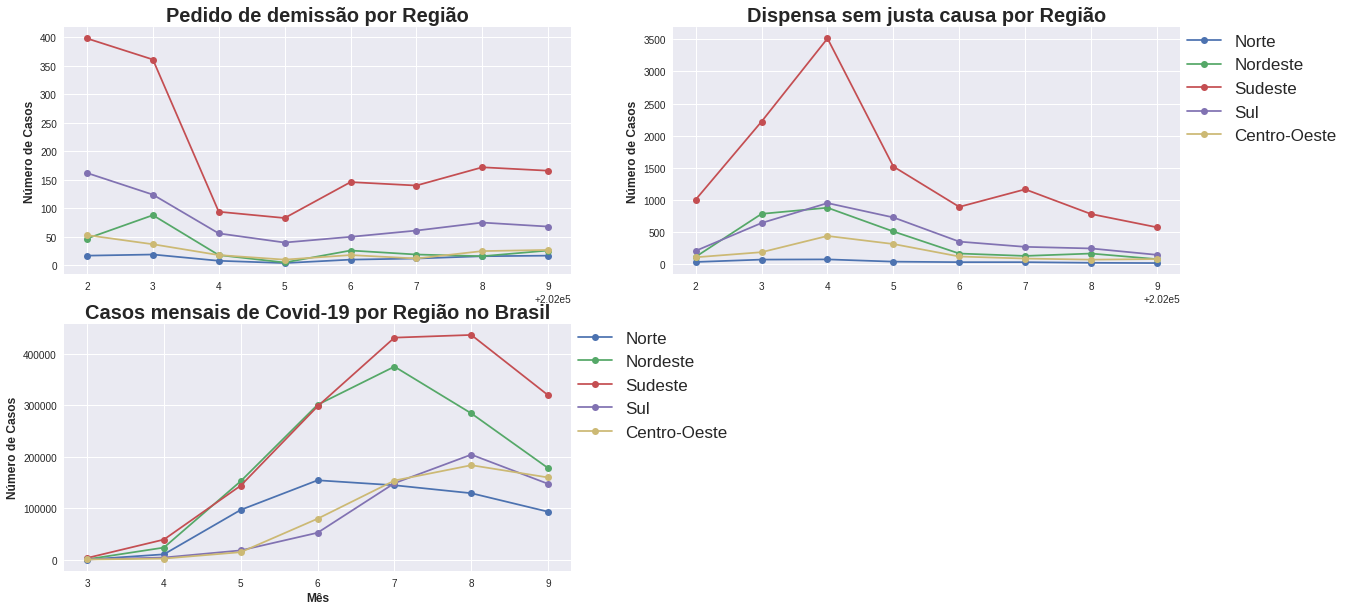

In [41]:
plt.figure(figsize=(20,10))

plt.subplot(222)
plt.plot(dispensa_sem_norte['competência'], dispensa_sem_norte['tipomovimentação'] ,'-o',  label = 'Norte')
plt.plot(dispensa_sem_nordeste['competência'], dispensa_sem_nordeste['tipomovimentação'] ,'-o', label = 'Nordeste')
plt.plot(dispensa_sem_sudeste['competência'], dispensa_sem_sudeste['tipomovimentação'] ,'-o',  label = 'Sudeste')
plt.plot(dispensa_sem_sul['competência'], dispensa_sem_sul['tipomovimentação'] ,'-o', label = 'Sul')
plt.plot(dispensa_sem_centro['competência'], dispensa_sem_centro['tipomovimentação'] ,'-o', label = 'Centro-Oeste')
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.title('Dispensa sem justa causa por Região', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 

plt.subplot(221)
plt.plot(pedido_demissão_norte['competência'], pedido_demissão_norte['tipomovimentação'] ,'-o',  label = 'Norte')
plt.plot(pedido_demissão_nordeste['competência'], pedido_demissão_nordeste['tipomovimentação'] ,'-o', label = 'Nordeste')
plt.plot(pedido_demissão_sudeste['competência'], pedido_demissão_sudeste['tipomovimentação'] ,'-o',  label = 'Sudeste')
plt.plot(pedido_demissão_sul['competência'], pedido_demissão_sul['tipomovimentação'] ,'-o', label = 'Sul')
plt.plot(pedido_demissão_centro['competência'], pedido_demissão_centro['tipomovimentação'] ,'-o', label = 'Centro-Oeste')
plt.title('Pedido de demissão por Região', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 

plt.subplot(223)
plt.plot(covid_norte['data'], covid_norte['casosNovos'],'-o' , label = 'Norte')
plt.plot(covid_nordeste['data'], covid_nordeste['casosNovos'],'-o' , label = 'Nordeste')
plt.plot(covid_sudeste['data'], covid_sudeste['casosNovos'],'-o' , label = 'Sudeste')
plt.plot(covid_sul['data'], covid_sul['casosNovos'],'-o' , label = 'Sul')
plt.plot(covid_centro['data'], covid_centro['casosNovos'],'-o' , label = 'Centro-Oeste')
plt.title('Casos mensais de Covid-19 por Região no Brasil', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.xlabel('Mês', fontsize=12, fontweight='bold') 

plt.show()


---
Normalizado(0,1):

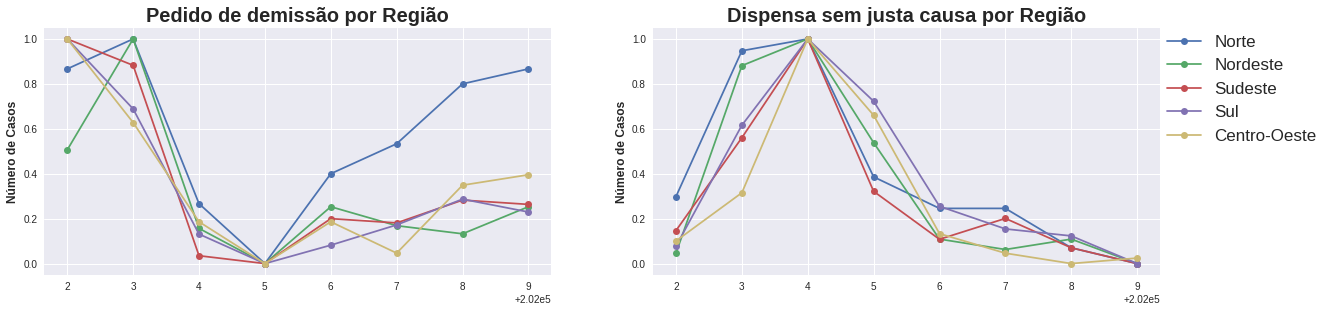

In [42]:
n_dispensa_sem_norte = normalizar(dispensa_sem_norte['tipomovimentação'].to_numpy())
n_dispensa_sem_nordeste = normalizar(dispensa_sem_nordeste['tipomovimentação'].to_numpy())
n_dispensa_sem_sudeste = normalizar(dispensa_sem_sudeste['tipomovimentação'].to_numpy())
n_dispensa_sem_sul = normalizar(dispensa_sem_sul['tipomovimentação'].to_numpy())
n_dispensa_sem_centro= normalizar(dispensa_sem_centro['tipomovimentação'].to_numpy())

n_pedido_demissão_norte = normalizar(pedido_demissão_norte['tipomovimentação'].to_numpy())
n_pedido_demissão_nordeste  = normalizar(pedido_demissão_nordeste ['tipomovimentação'].to_numpy())
n_pedido_demissão_sudeste = normalizar(pedido_demissão_sudeste['tipomovimentação'].to_numpy())
n_pedido_demissão_sul = normalizar(pedido_demissão_sul['tipomovimentação'].to_numpy())
n_pedido_demissão_centro = normalizar(pedido_demissão_centro['tipomovimentação'].to_numpy())

plt.figure(figsize=(20,10))

plt.subplot(222)
plt.plot(dispensa_sem_norte['competência'], n_dispensa_sem_norte ,'-o',  label = 'Norte')
plt.plot(dispensa_sem_nordeste['competência'],n_dispensa_sem_nordeste ,'-o', label = 'Nordeste')
plt.plot(dispensa_sem_sudeste['competência'], n_dispensa_sem_sudeste ,'-o',  label = 'Sudeste')
plt.plot(dispensa_sem_sul['competência'], n_dispensa_sem_sul ,'-o', label = 'Sul')
plt.plot(dispensa_sem_centro['competência'], n_dispensa_sem_centro ,'-o', label = 'Centro-Oeste')
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.title('Dispensa sem justa causa por Região', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 

plt.subplot(221)
plt.plot(pedido_demissão_norte['competência'], n_pedido_demissão_norte ,'-o',  label = 'Norte')
plt.plot(pedido_demissão_nordeste['competência'], n_pedido_demissão_nordeste ,'-o', label = 'Nordeste')
plt.plot(pedido_demissão_sudeste['competência'], n_pedido_demissão_sudeste ,'-o',  label = 'Sudeste')
plt.plot(pedido_demissão_sul['competência'], n_pedido_demissão_sul ,'-o', label = 'Sul')
plt.plot(pedido_demissão_centro['competência'],n_pedido_demissão_centro ,'-o', label = 'Centro-Oeste')
plt.title('Pedido de demissão por Região', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.show()

---
Normalizado(por 100mil habitantes):

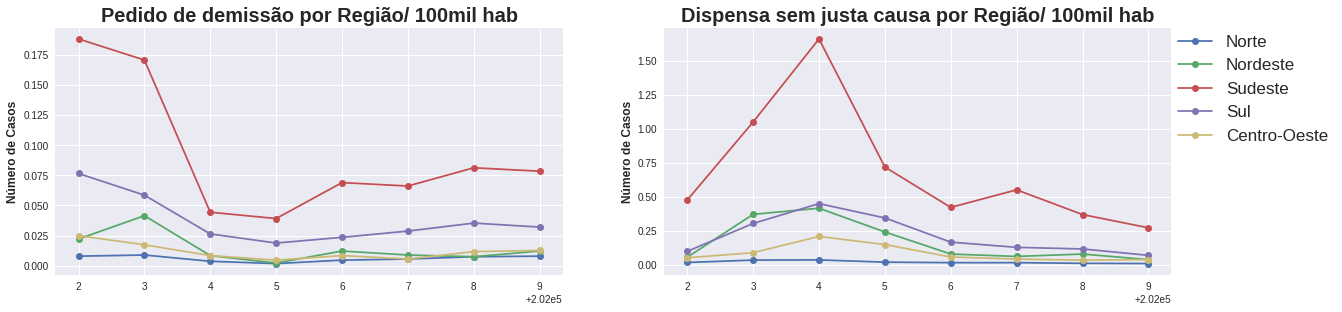

In [43]:
hn_dispensa_sem_norte = normalizar_100(dispensa_sem_norte['tipomovimentação'].to_numpy(),geral,hab)
hn_dispensa_sem_nordeste = normalizar_100(dispensa_sem_nordeste['tipomovimentação'].to_numpy(),geral,hab)
hn_dispensa_sem_sudeste = normalizar_100(dispensa_sem_sudeste['tipomovimentação'].to_numpy(),geral,hab)
hn_dispensa_sem_sul = normalizar_100(dispensa_sem_sul['tipomovimentação'].to_numpy(),geral,hab)
hn_dispensa_sem_centro= normalizar_100(dispensa_sem_centro['tipomovimentação'].to_numpy(),geral,hab)

hn_pedido_demissão_norte = normalizar_100(pedido_demissão_norte['tipomovimentação'].to_numpy(),geral,hab)
hn_pedido_demissão_nordeste  = normalizar_100(pedido_demissão_nordeste ['tipomovimentação'].to_numpy(),geral,hab)
hn_pedido_demissão_sudeste = normalizar_100(pedido_demissão_sudeste['tipomovimentação'].to_numpy(),geral,hab)
hn_pedido_demissão_sul = normalizar_100(pedido_demissão_sul['tipomovimentação'].to_numpy(),geral,hab)
hn_pedido_demissão_centro = normalizar_100(pedido_demissão_centro['tipomovimentação'].to_numpy(),geral,hab)

plt.figure(figsize=(20,10))

plt.subplot(222)
plt.plot(dispensa_sem_norte['competência'], hn_dispensa_sem_norte ,'-o',  label = 'Norte')
plt.plot(dispensa_sem_nordeste['competência'],hn_dispensa_sem_nordeste ,'-o', label = 'Nordeste')
plt.plot(dispensa_sem_sudeste['competência'], hn_dispensa_sem_sudeste ,'-o',  label = 'Sudeste')
plt.plot(dispensa_sem_sul['competência'], hn_dispensa_sem_sul ,'-o', label = 'Sul')
plt.plot(dispensa_sem_centro['competência'], hn_dispensa_sem_centro ,'-o', label = 'Centro-Oeste')
plt.legend(bbox_to_anchor=(1, 1), fontsize=17, loc='upper left', borderaxespad=0.)
plt.title('Dispensa sem justa causa por Região/ 100mil hab', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 

plt.subplot(221)
plt.plot(pedido_demissão_norte['competência'], hn_pedido_demissão_norte ,'-o',  label = 'Norte')
plt.plot(pedido_demissão_nordeste['competência'], hn_pedido_demissão_nordeste ,'-o', label = 'Nordeste')
plt.plot(pedido_demissão_sudeste['competência'], hn_pedido_demissão_sudeste ,'-o',  label = 'Sudeste')
plt.plot(pedido_demissão_sul['competência'], hn_pedido_demissão_sul ,'-o', label = 'Sul')
plt.plot(pedido_demissão_centro['competência'],hn_pedido_demissão_centro ,'-o', label = 'Centro-Oeste')
plt.title('Pedido de demissão por Região/ 100mil hab', fontsize=20, fontweight='bold') 
plt.ylabel('Número de Casos', fontsize=12, fontweight='bold') 
plt.show()


---
# Testes de Regressão

In [44]:
pearsons_norte, _ = pearsonr(dispensa_sem_norte['tipomovimentação'], covid_norte['casosNovos'])
pearsons_nordeste, _ = pearsonr(dispensa_sem_nordeste['tipomovimentação'], covid_nordeste['casosNovos'])
pearsons_sudeste, _ = pearsonr(dispensa_sem_sudeste['tipomovimentação'], covid_sudeste['casosNovos'])
pearsons_sul, _ = pearsonr(dispensa_sem_sul['tipomovimentação'], covid_sul['casosNovos'])
pearsons_centro, _ = pearsonr(dispensa_sem_centro['tipomovimentação'], covid_centro['casosNovos'])

print('Pearsons sem justa causa Norte: %.3f' % pearsons_norte)
print('Pearsons sem justa causa Nordeste: %.3f' % pearsons_nordeste)
print('Pearsons sem justa causa Sudeste: %.3f' % pearsons_sudeste)
print('Pearsons sem justa causa Sul: %.3f' % pearsons_sul)
print('Pearsons sem justa causa Centro-Oeste: %.3f' % pearsons_centro)


ValueError: x and y must have the same length.

In [ ]:
pearsons_norte, _ = pearsonr(caged_est_norte['admitidos'], covid_norte['casosNovos'])
pearsons_nordeste, _ = pearsonr(caged_est_nordeste['admitidos'], covid_nordeste['casosNovos'])
pearsons_sudeste, _ = pearsonr(caged_est_sudeste['admitidos'], covid_sudeste['casosNovos'])
pearsons_sul, _ = pearsonr(caged_est_sul['admitidos'], covid_sul['casosNovos'])
pearsons_centro, _ = pearsonr(caged_est_centro['admitidos'], covid_centro['casosNovos'])

print('Pearsons Admitidos Norte: %.3f' % pearsons_norte)
print('Pearsons Admitidos Nordeste: %.3f' % pearsons_nordeste)
print('Pearsons Admitidos Sudeste: %.3f' % pearsons_sudeste)
print('Pearsons Admitidos Sul: %.3f' % pearsons_sul)
print('Pearsons Admitidos Centro-Oeste: %.3f' % pearsons_centro)


In [ ]:
pearsons_norte, _ = pearsonr(origem_norte_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], covid_norte['casosNovos'])
pearsons_nordeste, _ = pearsonr(origem_nordeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], covid_nordeste['casosNovos'])
pearsons_sudeste, _ = pearsonr(origem_sudeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], covid_sudeste['casosNovos'])
pearsons_sul, _ = pearsonr(origem_sul_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], covid_sul['casosNovos'])
pearsons_centro, _ = pearsonr(origem_centro_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], covid_centro['casosNovos'])
print('Pearsons Viajens Norte: %.3f' % pearsons_norte)
print('Pearsons Viajens Nordeste: %.3f' % pearsons_nordeste)
print('Pearsons Viajens Sudeste: %.3f' % pearsons_sudeste)
print('Pearsons Viajens Sul: %.3f' % pearsons_sul)
print('Pearsons Viajens Centro-Oeste: %.3f' % pearsons_centro)

In [ ]:
pearsons_norte, _ = pearsonr(origem_norte_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], dispensa_sem_norte['tipomovimentação'])
pearsons_nordeste, _ = pearsonr(origem_nordeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], dispensa_sem_nordeste['tipomovimentação'])
pearsons_sudeste, _ = pearsonr(origem_sudeste_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], dispensa_sem_sudeste['tipomovimentação'])
pearsons_sul, _ = pearsonr(origem_sul_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], dispensa_sem_sul['tipomovimentação'])
pearsons_centro, _ = pearsonr(origem_centro_mes2020['AEROPORTO DE ORIGEM (PAÍS)'], dispensa_sem_centro['tipomovimentação'])

print('Pearsons Viajens/Desligados sem justa causa Norte: %.3f' % pearsons_norte)
print('Pearsons Viajens/Desligados sem justa causaNordeste: %.3f' % pearsons_nordeste)
print('Pearsons Viajens/Desligados sem justa causa Sudeste: %.3f' % pearsons_sudeste)
print('Pearsons Viajens/Desligados sem justa causa Sul: %.3f' % pearsons_sul)
print('Pearsons Viajens/Desligados sem justa causa Centro-Oeste: %.3f' % pearsons_centro)

In [ ]:
pearsons_norte, _ = pearsonr(pedido_demissão_norte['tipomovimentação'], covid_norte['casosNovos'])
pearsons_nordeste, _ = pearsonr(pedido_demissão_nordeste['tipomovimentação'], covid_nordeste['casosNovos'])
pearsons_sudeste, _ = pearsonr(pedido_demissão_sudeste['tipomovimentação'], covid_sudeste['casosNovos'])
pearsons_sul, _ = pearsonr(pedido_demissão_sul['tipomovimentação'], covid_sul['casosNovos'])
pearsons_centro, _ = pearsonr(pedido_demissão_centro['tipomovimentação'], covid_centro['casosNovos'])

print('Pearsons sem justa causa Norte: %.3f' % pearsons_norte)
print('Pearsons sem justa causa Nordeste: %.3f' % pearsons_nordeste)
print('Pearsons sem justa causa Sudeste: %.3f' % pearsons_sudeste)
print('Pearsons sem justa causa Sul: %.3f' % pearsons_sul)
print('Pearsons sem justa causa Centro-Oeste: %.3f' % pearsons_centro)

# Testes de Normalização
---

In [45]:
n_origem_regiao_mes2020

[1.0,
 0.7675619834710744,
 0.0,
 0.08109504132231404,
 0.1993801652892562,
 0.32334710743801653,
 0.38171487603305787,
 0.48088842975206614]

In [46]:
origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)']

0    2711
1    2261
2     775
3     932
4    1161
5    1401
6    1514
7    1706
Name: AEROPORTO DE ORIGEM (PAÍS), dtype: int64

In [47]:
teste = np.array(origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])

teste

array([2711, 2261,  775,  932, 1161, 1401, 1514, 1706])

In [48]:
n = preprocessing.normalize([teste])
n

array([[0.57223843, 0.47725234, 0.16358716, 0.19672675, 0.24506411,
        0.29572336, 0.31957542, 0.36010282]])

# Testes de Mudança Percentual
---

In [49]:
percentual(origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)'])

0         NaN
1   -0.165990
2   -0.657231
3    0.202581
4    0.245708
5    0.206718
6    0.080657
7    0.126816
Name: AEROPORTO DE ORIGEM (PAÍS), dtype: float64

In [50]:
origem_regiao_mes2020['AEROPORTO DE ORIGEM (PAÍS)'].pct_change()


0         NaN
1   -0.165990
2   -0.657231
3    0.202581
4    0.245708
5    0.206718
6    0.080657
7    0.126816
Name: AEROPORTO DE ORIGEM (PAÍS), dtype: float64

In [51]:
h_origem_regiao_mes2020.pct_change()

0         NaN
1   -0.165990
2   -0.657231
3    0.202581
4    0.245708
5    0.206718
6    0.080657
7    0.126816
Name: AEROPORTO DE ORIGEM (PAÍS), dtype: float64

In [52]:
ph_covid_norte = percentual(h_covid_norte)
ph_covid_nordeste = percentual(h_covid_nordeste) 
ph_covid_sudeste = percentual(h_covid_sudeste)
ph_covid_sul = percentual(h_covid_sul)
ph_covid_centro = percentual(h_covid_centro)

ph_covid_geral = percentual(h_covid_geral)
ph_covid_norte

0          NaN
1    34.629252
2     8.254415
3     0.593573
4    -0.062623
5    -0.106901
6    -0.278496
Name: casosNovos, dtype: float64

In [53]:
s_covid_norte = covid_norte['casosNovos'].sum()
s_covid_nordeste = covid_nordeste['casosNovos'].sum()
s_covid_sudeste = covid_sudeste['casosNovos'].sum()
s_covid_sul = covid_sul['casosNovos'].sum()
s_covid_centro =covid_centro['casosNovos'].sum()

print('Norte Covid: %3.f' % s_covid_norte)
print('Nordeste Covid: %3.f' % s_covid_nordeste)
print('Sudeste Covid: %3.f' % s_covid_sudeste)
print('Sul Covid: %3.f' % s_covid_sul)
print('Centro Covid: %3.f' % s_covid_centro)

Norte Covid: 629634
Nordeste Covid: 1316674
Sudeste Covid: 1673742
Sul Covid: 576123
Centro Covid: 594778


In [54]:
covid_norte['casosNovos']

0       294
1     10475
2     96940
3    154481
4    144807
5    129327
6     93310
Name: casosNovos, dtype: int64